In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%matplotlib inline

# exploring role of length of array!

$$\dot \theta_j = \omega_0 - \frac{K}{2} \left[ {\rm tanh} \left( \frac{ \cos\theta_{j-1} - \cos\theta_{j} - \beta}{h_{ol}} \right) + 1\right]  $$ 
$$ - \nu_p  \sin( \theta_j- \theta_{j+1}) -\nu_m \sin(\theta_j - \theta_{j-1})$$
$$ + \nu_{cp}  \cos( \theta_j- \theta_{j+1}) + \nu_{cm} \cos(\theta_j- \theta_{j-1})$$
$$ + A_c \cos(\theta_j + \theta_{j+1}) + A_s \sin(\theta_j + \theta_{j+1}) 
+ A_c \cos(\theta_j + \theta_{j-1}) + A_s \sin(\theta_j + \theta_{j-1})$$

The local Kuramoto model is $K_s = A_c = A_s = 0$ and $\nu >0$. 
The simple Niedermayer model has $\nu_p=\nu_p>0$ an $\nu_{cp} = \nu_{cm}>0$.

Sign or order of inside of $\nu_c$ cosine terms is irrelevant! 


This model encompases a vanilla phase oscillator model along with one sided overlap term and some terms
that involve sums of angles


$$ \cos(\theta_j + \theta_{j+1}  ) + \cos (\theta_j + \theta_{j-1})  = 2 \cos (( 2\theta_j + \theta_{j+1} + \theta_{j-1})/2) \cos((\theta_{j+1} - \theta_{j+1})/2) $$ 
$$ \sin(\theta_j + \theta_{j+1}  ) + \sin (\theta_j + \theta_{j-1})  = 
2 \sin (( 2\theta_j + \theta_{j+1} + \theta_{j-1})/2) \cos((\theta_{j+1} - \theta_{j+1})/2) $$

In [2]:
# functions for phase oscillator models 
# up is theta_j+1
# um is theta_j-1
# uj is theta_j

# function used to find dudt
def du_fun_overlap(up,uj,um,parms):
    omega0=parms[0]
    K    = parms[1]
    nu_p = parms[2]
    nu_m = parms[3]
    nu_cp = parms[4]
    nu_cm = parms[5]
    beta = parms[6]
    hor = parms[7]
    hol = hor
    A_c = parms[8]
    A_s = parms[9]
    #overlap_right = np.cos(uj) - np.cos(up) - beta
    #tor = K*0.5*(np.tanh(overlap_right/hor) + 1.)
    #du_j = omega0 - tor;
    overlap_left  = np.cos(um) - np.cos(uj) - beta
    tol = K*0.5*(np.tanh(overlap_left/hol) + 1.)
    du_j = omega0 - tol;
    du_j += nu_p*np.sin(up -uj)+ nu_m*np.sin(um-uj)  # some diffusion if you want it
    du_j += nu_cp*np.cos(up -uj)+ nu_cm*np.cos(um-uj)
    du_j += A_c*np.cos(uj + up) + A_s*np.sin(uj + up)  # neidermayer like sum terms
    du_j += A_c*np.cos(uj + um) + A_s*np.sin(uj + um)
    return du_j

# compute dudt
def du(func,u_arr,parms):
    up = np.copy(np.roll(u_arr,-1))  #periodic bc
    um = np.copy(np.roll(u_arr,1))
    uj = np.copy(u_arr)
    du_arr = func(up,uj,um,parms)
    return du_arr


isang = 1 # if u is an angle or not
twopi = 2*np.pi
#np.random.seed(2)


# take one step using 4th order Runge-kutta
# https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
# do a time step on the theta array
def update_onestep_rk4(func,u_arr,parms,dt):
    k1 = du(func,u_arr          ,parms)
    k2 = du(func,u_arr + dt*k1/2,parms)
    k3 = du(func,u_arr + dt*k2/2,parms)
    k4 = du(func,u_arr + dt*k3  ,parms)
    yn1 = u_arr + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0
    #u_arr = u_arr + dudt*dt
    u_arr = yn1
    # add Gaussian white noise. Its integral is a Wiener process (like random walk)
    eta = parms[12]
    #
    u_arr += np.sqrt(eta*dt)*np.random.normal(size=len(u_arr))
    if (isang==1):
        u_arr = np.mod(u_arr,twopi)
        
    return u_arr


# do nsteps time steps on the theta array
def update_nsteps(func,u_arr,parms,dt,nsteps):
    for i in range(nsteps):
        u_arr = update_onestep_rk4(func,u_arr,parms,dt)
    return u_arr

In [3]:
# different types of initial conditions
# iparms determine parmeters for initial conditions 
def give_init(N,iparms):
    eta_rand   =iparms[0]  # random uniform 
    slope_ramp =iparms[1]  # slope of a ramp
    mag_sin    =iparms[2]  # mag of a sine perturbation, 
    index_sin  =iparms[3]  # sets wavelength of sine
    phase_sin = iparms[4]  # set phase 
    peak       =iparms[5]  # make one point this value, choose point randomly
    iroll_ramp  =int(iparms[6])  # shift of the ramp, allows you to set step discontinuity location
    #npeaks     =iparms[5]  # if >1 then randomly choose npeaks positions to give a peak value
    u_arr = np.zeros(N)  #allocate, zero initial conditions 
    u_arr += eta_rand*np.random.random(size=N)  # random everywhere, uniform distn
    irr = int(np.random.random()*N)  # one randomly chosen location has value peak
    u_arr[irr] = peak 
    phi = np.random.random()*2*np.pi # randomly chosen phase
    for i in range(N): # sinusoidal
        #u_arr[i] += mag_sin*np.sin(2*np.pi*i*index_sin/N + phi)  # index_sin sets wavelength
        u_arr[i] += mag_sin*np.sin(2*np.pi*i*index_sin/N + phase_sin)  # index_sin sets wavelength
    ii = np.arange(N)
    ramp = (2*np.pi*slope_ramp*ii/N)
    ramp = np.roll(ramp,iroll_ramp)
    u_arr += ramp # ramp

    return u_arr%(2*np.pi)  # keep within [0,2pi]


In [4]:
# compute phase difference
# as defined in Denes+21
# phi_i = theta_i - theta_i-1 - 2 pi floor( (theta_i - theta_i-1 + pi) /2pi) 
# should return numbers between [-pi,pi]
# also returns the cummulative sum of the phase shifts
def phase_shift(u_arr):
    uj = np.copy(u_arr)
    um = np.roll(uj,1)
    fac = (uj - um + np.pi)/(2*np.pi)
    phi_j = uj - um - 2*np.pi*np.floor(fac)
    csum = np.cumsum(phi_j) # cummulative sum of the phase differences 
    return phi_j,csum
    

In [5]:

colorlist = ['red','orange','gold','green','dodgerblue','blue','magenta','violet','brown']
ncolorlist = len(colorlist)


# do integration
# fill an image with array outputs of uarr at different times
# start with nsteps, separation between outs is dn (in steps)
# and have ndn rows
# returns 2d arrays
# first one is nsteps*dt
# remaining separations are dn*dt
# number of outputs is ndn
# returns:
#  uarr arrays
#  dudt arrays
#  phase differences (as in Denes) arrays
#  winding number array for the output timestep
def mkphaseprofile(func,N,parms,dt,nsteps,dn,ndn,iparms):
    u_arr0 = give_init(N,iparms)  # get initial conditions
    ndt=0;
    nsteps_pass=nsteps  # number of steps to first one
    uout_arr = np.zeros((ndn,N))
    dudt_arr = np.zeros((ndn,N))
    dudj_arr = np.zeros((ndn,N))
    csum_arr = np.zeros((ndn,N))
    u_arr = update_nsteps(func,u_arr0,parms,dt,nsteps_pass) # integrate
    du_arr = du(func,u_arr,parms)
    phi_j,csum = phase_shift(u_arr) 
    du_dj = phi_j
    #du_dj = (np.roll(u_arr,-1) - u_arr)%twopi # u_j+1-u_j
    #kk = (du_dj > np.pi)
    #du_dj[kk] -= twopi
    uout_arr[0,:] = u_arr
    dudt_arr[0,:] = du_arr
    dudj_arr[0,:] = du_dj
    csum_arr[0,:] = csum
    nsteps_pass = dn #steps per row  # steps per row on subsequent ones
    winding_number = np.zeros(ndn)
    winding_number[0] = np.sum(phi_j)/(2*np.pi)
    for k in range(1,ndn):  #ndn is number of rows
        u_arr = update_nsteps(func,u_arr,parms,dt,nsteps_pass) # integrate
        du_arr = du(func,u_arr,parms)
        phi_j,csum = phase_shift(u_arr)  # compute phase shift as via Denes+11
        #du_dj = (np.roll(u_arr,-1) - u_arr)%twopi
        du_dj = phi_j
        #kk = (du_dj > np.pi)
        #du_dj[kk] -= twopi
        uout_arr[k,:] = u_arr
        dudt_arr[k,:] = du_arr
        dudj_arr[k,:] = du_dj  # is now phase shift
        winding_number[k] = np.sum(phi_j)/(2*np.pi)
        winding_number[k] = csum[-1]/(2*np.pi)
        csum_arr[k,:] = csum
          
    return uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number


# plot theta for a list of outputs
def pltlist(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ilist,ofile):
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3), \
                       sharex=True, sharey=False,dpi=300)
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        ax.plot(uarr,'o-',color=colorlist[i%ncolorlist],ms=2)
        print('t={:.2f}'.format(tarr[k]))
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)
        
        
# plot theta for a list of outputs
def pltlist_mean(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ilist,offsets,ofile):
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 2.2), \
                       sharex=True, sharey=False,dpi=300,facecolor='white')
    plt.subplots_adjust(left=0.15, right=0.98,\
                        bottom=0.22,top=0.98,hspace=0)
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        csum = np.sum(np.cos(uarr))
        ssum = np.sum(np.sin(uarr))
        umean = np.arctan2(ssum,csum)
        ushift = (uarr - umean + offsets[i] + np.pi)%(2*np.pi) -np.pi
        ax.plot(ushift,'o',color=colorlist[i%ncolorlist],ms=1,alpha=0.7)
        print('time t={:.2f}'.format(tarr[k]))
        
    ax.set_xlabel('index j',fontsize=14)
    ax.set_ylabel(r'$\theta$ + offset',fontsize=14)
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)   
        


In [6]:

# plots angle as an image along with winding number along with cummulative sum of phase diff
def newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,\
                dt,nsteps,dn,ndn,ofile,pos,alabel):
    nw=4
    fig, axarr = plt.subplots(nw, 1, figsize=(6, 4), \
                       sharex=True, sharey=False,dpi=300,facecolor='white')
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for k in range(nw):
        axarr[k].tick_params(axis='both', which='minor', labelsize=14)
        axarr[k].tick_params(axis='both', which='major', labelsize=14)
        
    ytx = axarr[0].yaxis.get_major_ticks()
    ytx = axarr[1].yaxis.get_major_ticks()
    ytx[-1].set_visible(False)
    ytx[0].set_visible(False)
    
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    jarr = np.arange(N+1)
    
    im0=axarr[0].pcolormesh(tarr,jarr,\
                np.transpose(uout_arr),vmin=0,vmax=twopi,cmap='hsv')
    l, b, w, h = axarr[0].get_position().bounds
    rect0 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb0 = fig.add_axes(rect0)
    fig.add_axes(ax_cb0)
    cbar0=plt.colorbar(im0,cax=ax_cb0,\
                    ticks=[0, np.pi, 2*np.pi],aspect=5,pad=0.02) 
    cbar0.ax.set_yticklabels(['0', r'$\pi$',r'$2\pi$'])
    cbar0.set_label(r'$\theta_j$',fontsize=14)
    
    im1=axarr[1].pcolormesh(tarr,jarr,\
                np.transpose(csum_arr)/(2*np.pi),cmap='rainbow')
    l, b, w, h = axarr[1].get_position().bounds
    rect1 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb1 = fig.add_axes(rect1)
    fig.add_axes(ax_cb1)
    cbar1=plt.colorbar(im1,cax=ax_cb1,\
                    aspect=5,pad=0.02) 
    cbar1.set_label(r'$w_j$',fontsize=14)
    
    im2=axarr[2].pcolormesh(tarr,jarr,np.transpose(dudj_arr),\
                vmin=-np.pi,vmax=np.pi,cmap='coolwarm')
    l, b, w, h = axarr[2].get_position().bounds
    rect2 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb2 = fig.add_axes(rect2)
    fig.add_axes(ax_cb2)
    cbar2=plt.colorbar(im2,cax=ax_cb2,\
                    ticks=[-np.pi,-np.pi/2,0,np.pi/2],aspect=5,pad=0.02) 
    cbar2.ax.set_yticklabels([r'-$\pi$',r'-$\pi$/2','0', r'$\pi$/2'])
    cbar2.set_label(r'$\phi_j$',fontsize=14)
    

    axarr[nw-1].plot(tarr[0:ndn],winding_number,'.',ms=3)
    axarr[nw-1].set_xlabel('time t',fontsize=14)
    axarr[nw-1].set_ylabel('winding w',fontsize=12)
    bottom, top = axarr[nw-1].get_ylim()
    if (np.abs(bottom) + np.abs(top) < 1.5):
        axarr[nw-1].set_ylim([-1.5,1.5])
    axarr[0].text(pos[0],pos[1],alabel,fontsize=16)
    for k in range(nw-1):
        axarr[k].set_ylabel('j',fontsize=14)
    
    
    if (len(ofile)>3):
        plt.savefig(ofile)
        


In [7]:
# compute standard deviation of phase diff array
def phivar(phi_arr):
    ss = np.shape(phi_arr)
    ndn = ss[0]
    phisig_arr = np.zeros(ndn)
    for k in range(ndn):
        #phimean = np.mean(phi_arr[k,:])
        phisig_arr[k] = np.std(phi_arr[k,:])
    return phisig_arr    
        

In [20]:
# loop over eta and length of array!
def doloop_NN(nu_p,nu_m,nu_cm,Nstart,eta_start,eta_fac,ni,nj,doit):
    
    dt=0.05
    func = du_fun_overlap
    ndn=600; dn=20; nsteps=dn
    print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
    parms = np.zeros(20)
    Ku=0.0;    hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; 
    omega0=1.0

    # initial conditions 
    eta_rand=0*np.pi; slope_ramp = 0.0; 
    peak = 0; iroll_ramp = 0
    index_sin = 4;  
    phase_sin = 0.0;
    mag_sin = 0.;
    #nu_p=0.01; nu_m=nu_p; 
    nu_cp = 0.0; #nu_cm = 0.5;
    
    #ni = 15; nj = 10
    NN_arr = np.zeros((ni,nj))
    w_arr = np.zeros((ni,nj))
    eta_arr = np.zeros((ni,nj))
    p_arr = np.zeros((ni,nj))
    winding_number = np.zeros(10)
    for i in range(ni):
        NN = int(Nstart*np.power(2,i))
        
        for j in range(nj):
            eta = eta_start*np.power(eta_fac,j);
            eta_arr[i,j] = eta
            NN_arr[i,j] = NN
            # lopsided niedermayer model with noise
            parms[0] = omega0
            parms[1] = Ku
            parms[2] = nu_p
            parms[3] = nu_m
            parms[4] = nu_cp
            parms[5] = nu_cm
            parms[6] = beta
            parms[7] = hol
            parms[8] = A_c
            parms[9] = A_s
            parms[12] = eta

            # initial conditions 
            iparms = np.array([eta_rand,slope_ramp, mag_sin, \
                               index_sin,phase_sin,peak,iroll_ramp])
            #u_arr0 = give_init(NN,iparms) #  not used
            
            if (doit==1):
                uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = \
                            mkphaseprofile(func,NN,parms,\
                                            dt,nsteps,dn,ndn,iparms)
            #print('eta={:.4f}, '.format(eta),\
            #    'w from {:.0f} to {:.0f}'.format(np.rint(winding_number[0])
            #                                    ,np.rint(winding_number[-1])))
            if (doit==1):
                w_arr[i,j] = np.rint(winding_number[-1]) #last winding number
                phisig_arr = phivar(dudj_arr)
                p_arr[i,j] = phisig_arr[-1]
                print(NN,eta)
        
    return NN_arr,eta_arr,w_arr,p_arr

Nstart1=32
nu_p1=0.01; nu_m1=nu_p1; nu_cm1=0.06
eta_start = 0.001
eta_fac= 1.6
ni = 8; nj = 8  #ni for NN 
NN_arr1,eta_arr1,w_arr1,p_arr1 =\
    doloop_NN(nu_p1,nu_m1,nu_cm1,Nstart1,eta_start,eta_fac,ni,nj,1)
print(np.max(NN_arr1),np.max(eta_arr1))

tmax = 601
32 0.001
32 0.0016
32 0.0025600000000000006
32 0.004096000000000001
32 0.0065536000000000014
32 0.010485760000000004
32 0.016777216000000008
32 0.02684354560000001
64 0.001
64 0.0016
64 0.0025600000000000006
64 0.004096000000000001
64 0.0065536000000000014
64 0.010485760000000004
64 0.016777216000000008
64 0.02684354560000001
128 0.001
128 0.0016
128 0.0025600000000000006
128 0.004096000000000001
128 0.0065536000000000014
128 0.010485760000000004
128 0.016777216000000008
128 0.02684354560000001
256 0.001
256 0.0016
256 0.0025600000000000006
256 0.004096000000000001
256 0.0065536000000000014
256 0.010485760000000004
256 0.016777216000000008
256 0.02684354560000001
512 0.001
512 0.0016
512 0.0025600000000000006
512 0.004096000000000001
512 0.0065536000000000014
512 0.010485760000000004
512 0.016777216000000008
512 0.02684354560000001
1024 0.001
1024 0.0016
1024 0.0025600000000000006
1024 0.004096000000000001
1024 0.0065536000000000014
1024 0.010485760000000004
1024 0.016777216

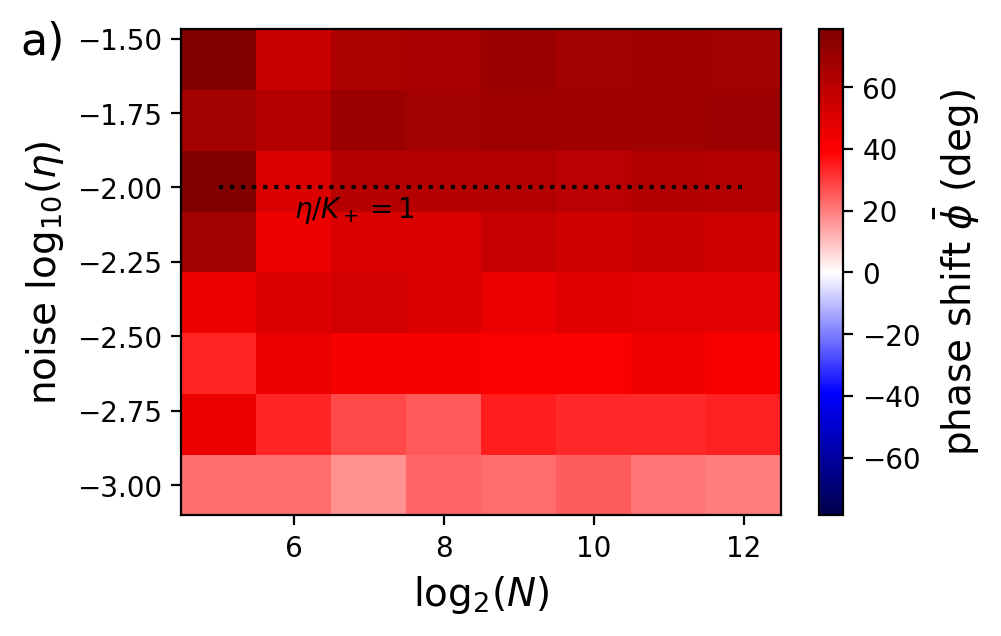

In [48]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.98)
phimean_deg = (w_arr1*2*np.pi/NN_arr1)  *180.0/np.pi
wmax=np.max(phimean_deg)
im=ax.pcolormesh(np.log2(NN_arr1),np.log10(eta_arr1),phimean_deg,cmap='seismic',\
                 vmin=-wmax,vmax=wmax)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_2(N)$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label(r'phase shift $\bar{\phi}$ (deg)',fontsize=14)
xlin = np.linspace(np.min(np.log2(NN_arr1)),np.max(np.log2(NN_arr1)),3)
ylin = np.log10(nu_p1) + 0*xlin
ax.plot(xlin,ylin,'k:')
ax.text(6,-2.1,r'$\eta/K_+=1$')

ax.text(2.35,-1.55,'a)',fontsize=16)
plt.savefig('NN_DN.png',dpi=300)

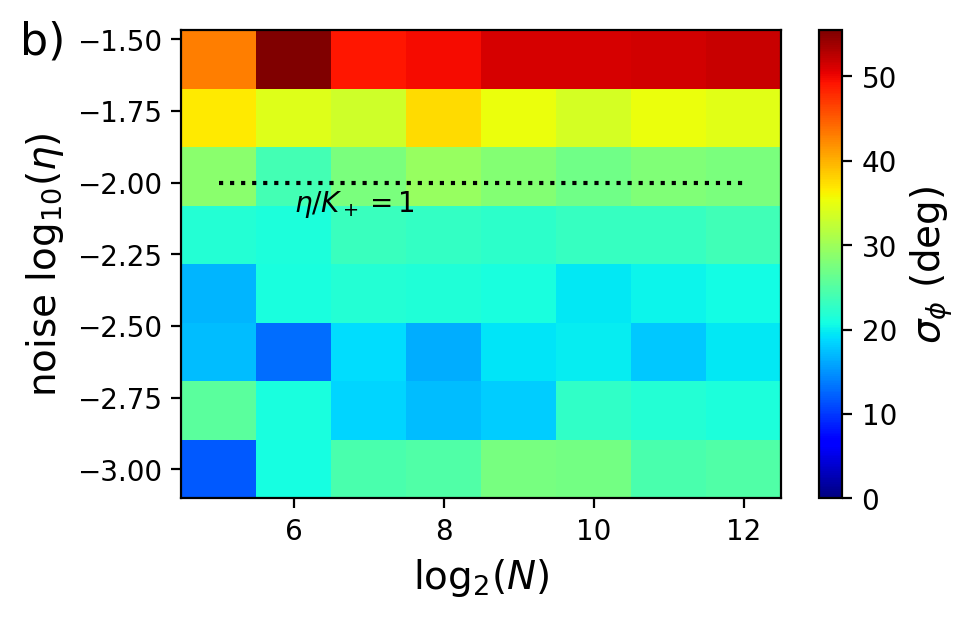

In [49]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.95)
#phimean1 = w_arr1*2*np.pi/NN_arr1
#wmax=np.max(phimean1)
im=ax.pcolormesh(np.log2(NN_arr1),np.log10(eta_arr1),p_arr1*180/np.pi,cmap='jet',vmin=0)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_2(N)$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)
xlin = np.linspace(np.min(np.log2(NN_arr1)),np.max(np.log2(NN_arr1)),3)
ylin = np.log10(nu_p1) + 0*xlin
ax.plot(xlin,ylin,'k:')
ax.text(6,-2.1,r'$\eta/K_+=1$')

ax.text(2.35,-1.55,'b)',fontsize=16)
plt.savefig('NN_DN_sig.png',dpi=300)

In [42]:
# do another run with nucm=0
Nstart3=32
nu_p3=0.01; nu_m3=nu_p3; nu_cm3=0.0
eta_start = 0.001
eta_fac= 1.6
ni = 8; nj = 8  #ni for NN 
NN_arr3,eta_arr3,w_arr3,p_arr3 =\
    doloop_NN(nu_p3,nu_m3,nu_cm3,Nstart3,eta_start,eta_fac,ni,nj,1)
print(np.max(NN_arr3),np.max(eta_arr3))

tmax = 601
32 0.001
32 0.0016
32 0.0025600000000000006
32 0.004096000000000001
32 0.0065536000000000014
32 0.010485760000000004
32 0.016777216000000008
32 0.02684354560000001
64 0.001
64 0.0016
64 0.0025600000000000006
64 0.004096000000000001
64 0.0065536000000000014
64 0.010485760000000004
64 0.016777216000000008
64 0.02684354560000001
128 0.001
128 0.0016
128 0.0025600000000000006
128 0.004096000000000001
128 0.0065536000000000014
128 0.010485760000000004
128 0.016777216000000008
128 0.02684354560000001
256 0.001
256 0.0016
256 0.0025600000000000006
256 0.004096000000000001
256 0.0065536000000000014
256 0.010485760000000004
256 0.016777216000000008
256 0.02684354560000001
512 0.001
512 0.0016
512 0.0025600000000000006
512 0.004096000000000001
512 0.0065536000000000014
512 0.010485760000000004
512 0.016777216000000008
512 0.02684354560000001
1024 0.001
1024 0.0016
1024 0.0025600000000000006
1024 0.004096000000000001
1024 0.0065536000000000014
1024 0.010485760000000004
1024 0.016777216

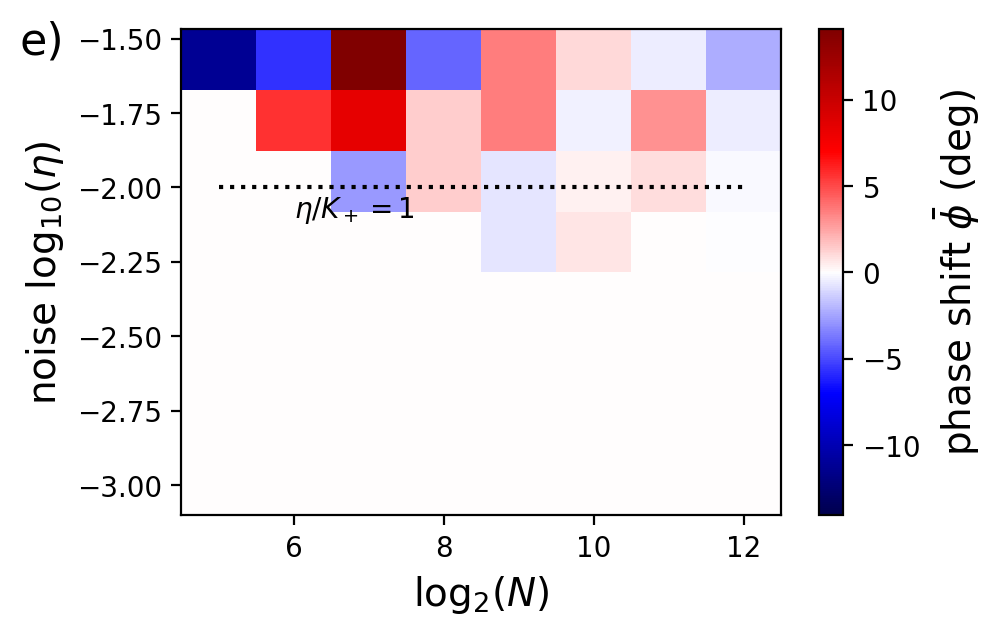

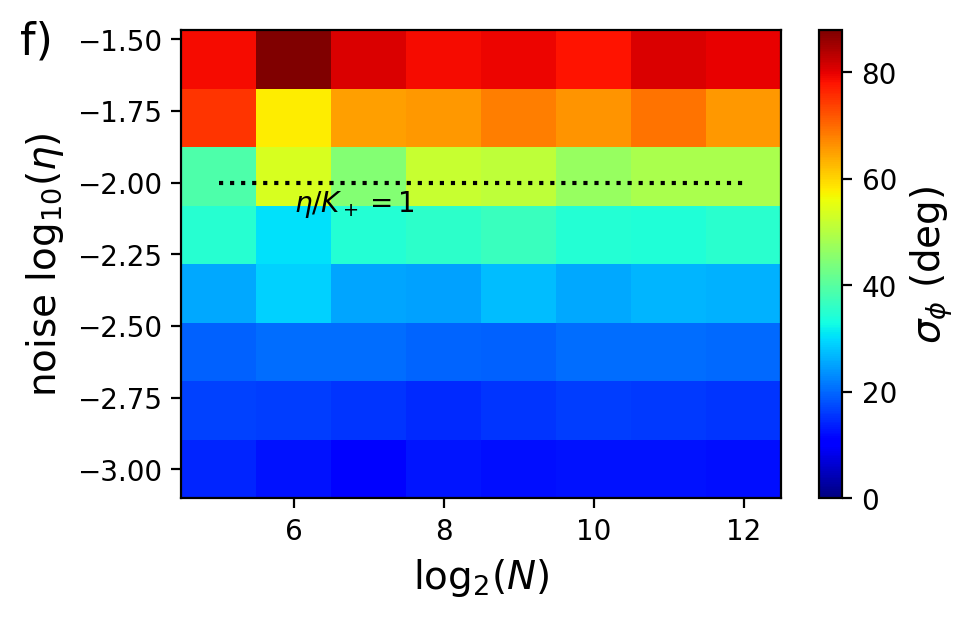

In [60]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.98)
phimean_deg = (w_arr3*2*np.pi/NN_arr1)  *180.0/np.pi
wmax=np.max(np.abs(phimean_deg))
im=ax.pcolormesh(np.log2(NN_arr3),np.log10(eta_arr3),phimean_deg,cmap='seismic',\
                 vmin=-wmax,vmax=wmax)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_2(N)$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label(r'phase shift $\bar{\phi}$ (deg)',fontsize=14)
xlin = np.linspace(np.min(np.log2(NN_arr3)),np.max(np.log2(NN_arr3)),3)
ylin = np.log10(nu_p3) + 0*xlin
ax.plot(xlin,ylin,'k:')
ax.text(6,-2.1,r'$\eta/K_+=1$')

ax.text(2.35,-1.55,'e)',fontsize=16)
plt.savefig('NN_BN.png',dpi=300)

fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.95)
im=ax.pcolormesh(np.log2(NN_arr3),np.log10(eta_arr3),p_arr3*180/np.pi,cmap='jet',vmin=0)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_2(N)$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)
xlin = np.linspace(np.min(np.log2(NN_arr3)),np.max(np.log2(NN_arr3)),3)
ylin = np.log10(nu_p3) + 0*xlin
ax.plot(xlin,ylin,'k:')
ax.text(6,-2.1,r'$\eta/K_+=1$')

ax.text(2.35,-1.55,'f)',fontsize=16)
plt.savefig('NN_BN_sig.png',dpi=300)

In [26]:
# loop over eta and length of array!
def doloop_NN_ov(nu_p,Ku,Nstart,eta_start,eta_fac,ni,nj,doit):
    
    dt=0.05
    func = du_fun_overlap
    ndn=600; dn=20; nsteps=dn
    print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
    parms = np.zeros(20)
    #Ku=0.0;    
    hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; 
    omega0=1.0

    # initial conditions 
    eta_rand=0*np.pi; slope_ramp = 0.0; 
    peak = 0; iroll_ramp = 0
    index_sin = 4;  
    phase_sin = 0.0;
    mag_sin = 0.;
    nu_cp = 0.0; nu_cm = 0.0;
    nu_m = nu_p
    
    #ni = 15; nj = 10
    NN_arr = np.zeros((ni,nj))
    w_arr = np.zeros((ni,nj))
    eta_arr = np.zeros((ni,nj))
    p_arr = np.zeros((ni,nj))
    winding_number = np.zeros(10)
    for i in range(ni):
        NN = int(Nstart*np.power(2,i))
        
        for j in range(nj):
            eta = eta_start*np.power(eta_fac,j);
            eta_arr[i,j] = eta
            NN_arr[i,j] = NN
            # lopsided niedermayer model with noise
            parms[0] = omega0
            parms[1] = Ku
            parms[2] = nu_p
            parms[3] = nu_m
            parms[4] = nu_cp
            parms[5] = nu_cm
            parms[6] = beta
            parms[7] = hol
            parms[8] = A_c
            parms[9] = A_s
            parms[12] = eta

            # initial conditions 
            iparms = np.array([eta_rand,slope_ramp, mag_sin, \
                               index_sin,phase_sin,peak,iroll_ramp])
            #u_arr0 = give_init(NN,iparms) #  not used
            
            if (doit==1):
                uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = \
                            mkphaseprofile(func,NN,parms,\
                                            dt,nsteps,dn,ndn,iparms)
            #print('eta={:.4f}, '.format(eta),\
            #    'w from {:.0f} to {:.0f}'.format(np.rint(winding_number[0])
            #                                    ,np.rint(winding_number[-1])))
            if (doit==1):
                w_arr[i,j] = np.rint(winding_number[-1]) #last winding number
                phisig_arr = phivar(dudj_arr)
                p_arr[i,j] = phisig_arr[-1]
                print(NN,eta)
        
    return NN_arr,eta_arr,w_arr,p_arr

Nstart2=32
nu_p2=0.01; Ku2=0.2
eta_start = 0.001
eta_fac= 1.6
ni = 8; nj = 8  #ni for NN 
NN_arr2,eta_arr2,w_arr2,p_arr2 =\
    doloop_NN_ov(nu_p2,Ku2,Nstart2,eta_start,eta_fac,ni,nj,1)
print(np.max(NN_arr2),np.max(eta_arr2))

tmax = 601
32 0.001
32 0.0016
32 0.0025600000000000006
32 0.004096000000000001
32 0.0065536000000000014
32 0.010485760000000004
32 0.016777216000000008
32 0.02684354560000001
64 0.001
64 0.0016
64 0.0025600000000000006
64 0.004096000000000001
64 0.0065536000000000014
64 0.010485760000000004
64 0.016777216000000008
64 0.02684354560000001
128 0.001
128 0.0016
128 0.0025600000000000006
128 0.004096000000000001
128 0.0065536000000000014
128 0.010485760000000004
128 0.016777216000000008
128 0.02684354560000001
256 0.001
256 0.0016
256 0.0025600000000000006
256 0.004096000000000001
256 0.0065536000000000014
256 0.010485760000000004
256 0.016777216000000008
256 0.02684354560000001
512 0.001
512 0.0016
512 0.0025600000000000006
512 0.004096000000000001
512 0.0065536000000000014
512 0.010485760000000004
512 0.016777216000000008
512 0.02684354560000001
1024 0.001
1024 0.0016
1024 0.0025600000000000006
1024 0.004096000000000001
1024 0.0065536000000000014
1024 0.010485760000000004
1024 0.016777216

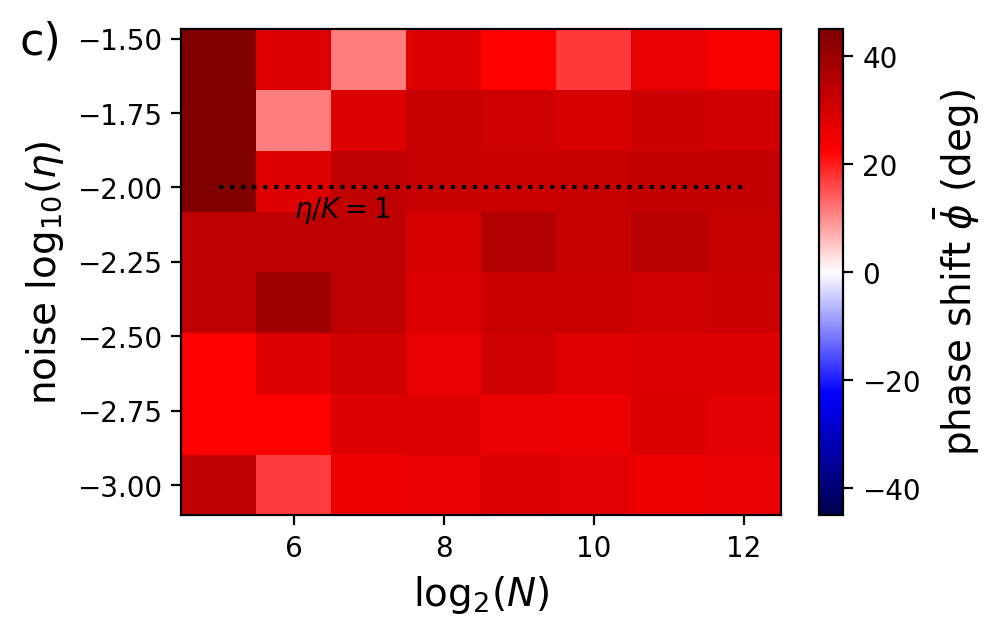

In [53]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.98)
phimean_deg = (w_arr2*2*np.pi/NN_arr2)  *180.0/np.pi
wmax=np.max(phimean_deg)
im=ax.pcolormesh(np.log2(NN_arr2),np.log10(eta_arr2),phimean_deg,cmap='seismic',\
                 vmin=-wmax,vmax=wmax)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_2(N)$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label(r'phase shift $\bar{\phi}$ (deg)',fontsize=14)
xlin = np.linspace(np.min(np.log2(NN_arr2)),np.max(np.log2(NN_arr2)),3)
ylin = np.log10(nu_p2) + 0*xlin
ax.plot(xlin,ylin,'k:')
ax.text(6,-2.1,r'$\eta/K=1$')

ax.text(2.35,-1.55,'c)',fontsize=16)
plt.savefig('NN_OVN.png',dpi=300)

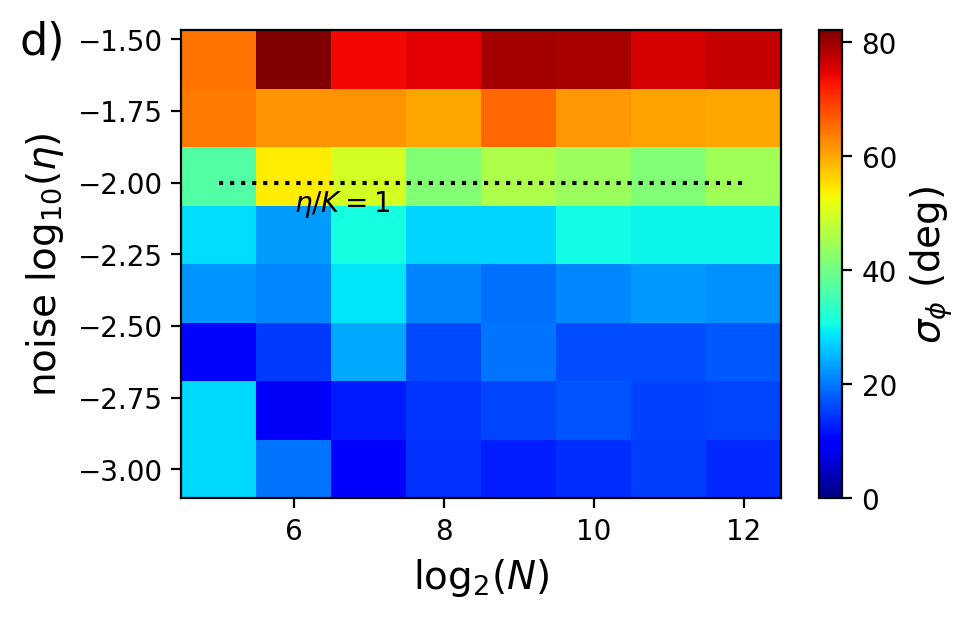

In [54]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.17,right=0.92,bottom=0.17,top=0.95)

im=ax.pcolormesh(np.log2(NN_arr2),np.log10(eta_arr2),p_arr2*180/np.pi,cmap='jet',vmin=0)
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_2(N)$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)
xlin = np.linspace(np.min(np.log2(NN_arr2)),np.max(np.log2(NN_arr2)),3)
ylin = np.log10(nu_p2) + 0*xlin
ax.plot(xlin,ylin,'k:')
ax.text(6,-2.1,r'$\eta/K=1$')


ax.text(2.35,-1.55,'d)',fontsize=16)
plt.savefig('NN_OVN_sig.png',dpi=300)

In [62]:
2**12

4096